## original image -> $f( \theta )$ -> output mask

In [1]:
import numpy as np
import pathlib
import pandas as pd
import numba, cv2, gc, os, glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from albumentations import *

import torch
import torch.nn as nn

from segmentation_models_pytorch.unet import Unet
# from segmentation_models_pytorch.deeplabv3 import DeepLabV3Plus

from segmentation_models_pytorch.encoders import get_preprocessing_fn

import warnings
warnings.filterwarnings('ignore')

import re

In [2]:
import os

os.chdir("../02_Research/00_Experimental Data/20210127_purewater/")
print(os.getcwd())

C:\Users\kakum\Desktop\02_Research\00_Experimental Data\20210127_purewater


In [2]:
class DropletModel(nn.Module):
    def __init__(self):
        super(DropletModel, self).__init__()
        self.model = Unet(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [5]:
ENCODER_NAME = 'efficientnet-b4'
# device = 'cuda'

device = 'cpu'

models_path = '../fold0_epoch11.pth'

preprocessing_fn = Lambda(image = get_preprocessing_fn(encoder_name = ENCODER_NAME,
                                                            pretrained = 'imagenet'))
model = DropletModel()
model.load_state_dict(torch.load(models_path, map_location=torch.device('cpu')))
model.float()
model.to(device)
model.eval()

data_dir_lst = ["20210507_PW_1",]

for data_dir in data_dir_lst:
    data_dir_path = f"./{data_dir}/"
    img_lst = glob.glob(data_dir_path + "*.png")

    for img_path in img_lst:
        img_name = ".".join(re.split("[./\\\]", img_path)[-3:-1])

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = preprocessing_fn(image = img)['image']
        # change channel to be the first
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).view([1, 3, 480, 640]).to(device)

        pred_mask_btch = model(img.float())

        pred = pred_mask_btch.detach().numpy().squeeze()

        pred[pred<0] = 0
        pred[pred>0] = 255
        cv2.imwrite(data_dir_path + img_name + "_mask.png", pred)

## Check of results

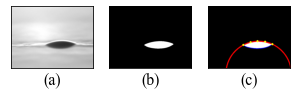

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 16,}

mask = cv2.imread("./l130_6/22133.333ms_mask.png")
image = cv2.imread("./l130_6/22133.333ms.png")

plt.figure(figsize=(5, 4))

plt.subplot(1, 3, 1)
image = image[:, :, ::-1]
plt.imshow(image)
plt.xlabel("(a)", font)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
plt.imshow(mask, cmap="gray")
plt.xlabel("(b)", font)
plt.xticks([])
plt.yticks([])

# image[..., 0] = np.where(mask == 255, 255, image[..., 0])
# plt.subplot(1, 3, 3)
# plt.imshow(image)
# plt.xlabel("(c)", font)
# plt.xticks([])
# plt.yticks([])

plt.subplot(1, 3, 3)
processed_img = cv2.imread("./l130_6/22133.333ms_mask_processed.png")
mask = processed_img[:, :, ::-1]
plt.imshow(mask)
plt.xlabel("(c)", font)
plt.xticks([])
plt.yticks([])

plt.savefig("../compare2.svg", dpi=500)
plt.show()

## mask image -> physical parameters(.csv)

In [3]:
def cal_line(x1, y1, x2, y2, x_y, flag):
    # 1 means horizontal
    if flag == 1:
        if y1 == y2:
            return y1
        else:
            k = (y2 - y1) / (x2 - x1)
            b = (x1 * y2 - x2 * y1) / (x1 - x2)
            x3 = x_y
            y3 = int(k * x3 + b)
        return y3
    else:
        if x1 == x2:
            return x1
        else:
            k = (y2 - y1) / (x2 - x1)
            b = (x1 * y2 - x2 * y1) / (x1 - x2)
            y3 = x_y
            x3 = int((y3 - b) / k)
            return x3

pixel_len1 = 0.9748102696798955 # 5x
pixel_len2 = 0.2418065541763232 # 20x

In [4]:
import pandas as pd
import glob
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
from calculate_volume import get_sphere, get_volume, get_contact_angle, get_distance, get_surface_area
import math

# papar_lst = ["l90", "l130", "l200", "l250", "o73", "o84", "o104", "o128"]
papar_lst = [ "o73" ]
data_dir_lst = []
for paper_name in papar_lst:
    for i in range(1, 8):
        data_dir_lst.append(f"{paper_name}_{i}")


for data_dir in data_dir_lst:
    data_dir_path = f"./{data_dir}/"
    if not os.path.exists(data_dir_path):
        continue
    
    img_lst = glob.glob(data_dir_path + "*ms_mask.png")
    img_lst = sorted(img_lst, key=lambda x: float(".".join(re.split("[./\\\m]", x)[-5:-3])) )

    result_dict = {}
    for s in ["time[ms]", "bottom_radius[um]", "theta[degree]", "height[um]", "area[m^2]", "Mj[pL]"]:
        result_dict[s] = []

    for n, img_path in enumerate(img_lst):
        img_name = ".".join(re.split("[./\\\]", img_path)[-3:-1])
#         print(float(".".join(re.split("[./\\\m]", img_path)[-5:-3])))
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        
        height, width = img.shape
        
        contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contours = sorted(contours, key=lambda c: cv2.arcLength(c, False), reverse=True)
        
        # x1, y1: bottom left; x2, y2, bottom right;
        x1 = contours[0].min(axis=0).squeeze()[0]
        x2 = contours[0].max(axis=0).squeeze()[0]
        
        points_arr1 = contours[0].squeeze()[np.where(contours[0].squeeze() == x1)[0]]
        points_arr2 = contours[0].squeeze()[np.where(contours[0].squeeze() == x2)[0]]
        
        y1, y2 = height, height
        for i, (x, y) in enumerate(points_arr1):
            if x == x1 and y < y1:
                y1 = y
        
        for i, (x, y) in enumerate(points_arr2):
            if x == x2 and y < y2:
                y2 = y
        
#         print(x1, y1)
#         print(x2, y2)
        
        # x0, y0: central point of bottom
        x0 = int((x1 + x2) / 2)
        y0 = int((y1 + y2) / 2)
        
        vector1 = np.array([x2 - x1, y2 - y1])
        
        inner_product = []
        for idx, (cnt_x, cnt_y) in enumerate(contours[0].squeeze()):
            min_idx = 0
            inner_product = np.nan
            line_y = cal_line(x1, y1, x2, y2, cnt_x, 1)
            if cnt_y <= line_y:
                vector2 = np.array([x0 - cnt_x, y0 - cnt_y])
                if abs(np.inner(vector1, vector2)) < inner_product:
                    inner_product = abs(np.inner(vector1, vector2))
                    min_idx = idx
        # x3, y3 top point
        x3, y3 = contours[0].squeeze()[min_idx]
        
        # x4, y4: left top; x5, y5: right top;
        x4 = int(x1 + ((x2 - x1) / 4))
        x5 = int(x2 - ((x2 - x1) / 4))
        points_arr4 = contours[0].squeeze()[np.where(contours[0].squeeze() == x4)[0]]
        points_arr5 = contours[0].squeeze()[np.where(contours[0].squeeze() == x5)[0]]
        
        y4, y5 = cal_line(x1, y1, x2, y2, x4, 1), cal_line(x1, y1, x2, y2, x5, 1)
        for i, (x, y) in enumerate(points_arr4):
            if x == x4 and y < y4:
                y4 = y
        for i, (x, y) in enumerate(points_arr5):
            if x == x5 and y < y5:
                y5 = y
        
        # Calculate
        center_x1, center_y1, R1 = get_sphere(x1, y1, x2, y2, x3, y3)
        center_x2, center_y2, R2 = get_sphere(x1, y1, x2, y2, x4, y4)
        center_x3, center_y3, R3 = get_sphere(x1, y1, x2, y2, x5, y5)
        
        center_x, center_y, R = np.mean([center_x1, center_x2, center_x3]), \
                                np.mean([center_y1, center_y2, center_y3]), \
                                np.mean([R1, R2, R3])
        
        # bottom radius
        r = (math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) / 2) * pixel_len2  # um
        R = R * pixel_len2  # um
        # droplet height
        h = R - math.sqrt(R ** 2 - r ** 2)
        # contact angle
        theta = get_contact_angle(h, r)
        V = get_volume(r, h)  # pL
        S = get_surface_area(R, h) * 10 ** (-12) # m^2
        
        time_ms = n / 60 * 1000 # ms

        result_dict["time[ms]"].append(time_ms)
        result_dict["bottom_radius[um]"].append(r)
        result_dict["theta[degree]"].append(theta)
        result_dict["height[um]"].append(h)
        result_dict["area[m^2]"].append(S)
        result_dict["Mj[pL]"].append(V)
        
        # show the results
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img, contours, -1, (255,0,0), thickness=3)
        cv2.circle(img, (int(center_x), int(center_y)), int(R / pixel_len2), (0, 0, 255), 4)
        cv2.circle(img, (x3, y3), 4, (0, 255, 255), 8)
        cv2.circle(img, (x1, y1), 1, (0, 255, 255), 8)
        cv2.circle(img, (x2, y2), 1, (0, 255, 255), 8)
        cv2.circle(img, (x4, y4), 1, (0, 255, 255), 8)
        cv2.circle(img, (x5, y5), 1, (0, 255, 255), 8)
        
        cv2.imwrite(f"./{data_dir}/{img_name}_processed.png", img)

    df = pd.DataFrame(result_dict)
    df.to_csv(f"./output_results/{data_dir}.csv", index=False)

## Use Otsu

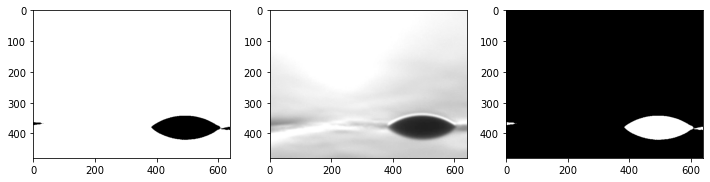

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

mask = cv2.imread("./o104_3/9300.000ms_mask.png")
image = cv2.imread("./o104_3/9300.000ms.png")

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(binary_img, cmap="gray")

plt.subplot(1, 3, 2)
image = image[:, :, ::-1]
plt.imshow(image)

plt.subplot(1, 3, 3)
mask = cv2.bitwise_not(binary_img)
plt.imshow(mask, cmap="gray")

# image[..., 0] = np.where(mask == 255, 255, image[..., 0])
# plt.subplot(1, 3, 3)
# plt.imshow(image)

# plt.savefig("../output_results/compare.png", dpi=300)
plt.show()

In [32]:
data_dir_path = f"./o104_3/"
img_lst = glob.glob(data_dir_path + "*ms.png")


for i, img_path in enumerate(img_lst):
    img_name = ".".join(re.split("[./\\\]", img_path)[-3:-1])

    gray_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = cv2.bitwise_not(binary_img)

    cv2.imwrite(data_dir_path + img_name + "_mask.png", mask)
    
    if i == 17:
        break